In [1285]:
import os
import socket
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import types as T, functions as F, SparkSession
from pyspark.sql.window import Window
from pyspark import StorageLevel
from jinja2 import Environment, FileSystemLoader
import datetime
import json

In [1286]:
LOGIN = 'arozanov-370043' 
APP_NAME = "spark-1"  # Any name for your Spark-app

In [1287]:
NORMALIZED_APP_NAME = APP_NAME.replace('/', '_').replace(':', '_').replace(' ', '_').replace('\\', '_')

APPS_TMP_DIR = os.path.join(os.getcwd(), "tmp")
APPS_CONF_DIR = os.path.join(os.getcwd(), "conf")
APPS_LOGS_DIR = os.path.join(os.getcwd(), "logs")
LOG4J_PROP_FILE = os.path.join(APPS_CONF_DIR, "pyspark-log4j-{}.properties".format(NORMALIZED_APP_NAME))
LOG_FILE = os.path.join(APPS_LOGS_DIR, 'pyspark-{}.log'.format(NORMALIZED_APP_NAME))
EXTRA_JAVA_OPTIONS = (
    "-Dlog4j.configuration=file://{} "
    "-Dspark.hadoop.dfs.replication=1 "
    "-Dhttps.protocols=TLSv1.0,TLSv1.1,TLSv1.2,TLSv1.3"
    .format(LOG4J_PROP_FILE)
)

LOCAL_IP = socket.gethostbyname(socket.gethostname())

In [1288]:
for directory in [APPS_CONF_DIR, APPS_LOGS_DIR, APPS_TMP_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

env = Environment(loader=FileSystemLoader('/opt'))
template = env.get_template("pyspark_log4j.properties.template")
template.stream(logfile=LOG_FILE).dump(LOG4J_PROP_FILE)

In [1289]:
spark = (
    SparkSession
    .builder
    .appName(APP_NAME)
    
    # Master URI/configuration
    .master("k8s://https://10.32.7.103:6443")
    
    .config("spark.driver.host", LOCAL_IP)
    
    # Web-UI port for your Spark-app
    .config("spark.ui.port", "4040")
    .config("spark.driver.bindAddress", "0.0.0.0")
    
    # How many CPU cores allocate to driver process
    .config("spark.driver.cores", "2")
    
    # How many RAM allocate to driver process
    .config("spark.driver.memory", "4g")
    
    # How many executors to create
    .config("spark.executor.instances", "3")
    
    # How many CPU cores allocate to each executor
    .config("spark.executor.cores", '2')
    
    # How many RAM allocate to each executor
    .config("spark.executor.memory", "4g")
    
    # How many extra RAM allocate to each executor pod to handle with JVM overheads
    # Total pod RAM = 'spark.executor.memory' + ('spark.executor.memory' * 'spark.kubernetes.memoryOverheadFactor')
    .config("spark.kubernetes.memoryOverheadFactor", "0.2")
    
    # How many RAM from the pool allocate to store the data
    # Additional info: https://spark.apache.org/docs/latest/tuning.html#memory-management-overview
    .config("spark.memory.fraction", "0.6")
    .config("spark.memory.storageFraction", "0.5")
    
    .config("spark.network.timeout", "180s")
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")
    .config("spark.driver.extraJavaOptions", EXTRA_JAVA_OPTIONS)
    
    # Namespace to create executor pods. You are allowed to create pods only in your own namespace
    .config("spark.kubernetes.namespace", LOGIN)
    
    # Extra labels to your driver/executor pods in Kubernetes
    .config("spark.kubernetes.driver.label.appname", APP_NAME)
    .config("spark.kubernetes.executor.label.appname", APP_NAME)
    
    # Spark executor image
    .config("spark.kubernetes.container.image", f"node03.st:5000/spark-executor:{LOGIN}")

    .config("spark.kubernetes.container.image.pullPolicy", "Always")
    
    # If true - delete completed/failed pods. 
    # If your executors goes down you can set 'false' to check logs and troubleshoot your app.
    .config("spark.kubernetes.executor.deleteOnTermination", "true")
    
    .config("spark.local.dir", "/tmp/spark")
    .getOrCreate()
)

In [1290]:
DATA_PATH = "hdfs:///shared/bigdata20"
itmo_posts_df = spark.read.json(f"{DATA_PATH}/posts_api.json")

In [1291]:
itmo_posts_df.printSchema()

root
 |-- attachments: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- album: struct (nullable = true)
 |    |    |    |-- created: long (nullable = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |-- size: long (nullable = true)
 |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |-- access_key: string (nullable = true)
 |    |    |    |    |-- album_id: long (nullable = true)
 |    |    |    |    |-- date: long (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |    |-- sizes: array (nullable = true)
 |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |    |-- height: long (nullable = true)
 |    |    |    |    |    |    |-- type: string (nullable = true)
 |   

In [1292]:
followers_posts_likes_df = spark.read.parquet(f"{DATA_PATH}/followers_posts_likes.parquet")
followers_posts_df = spark.read.json(f"{DATA_PATH}/followers_posts_api_final.json")

# Task 1
## a

In [822]:
def task_1a(df: "pyspark.sql.dataframe.DataFrame", 
            F: "pyspark.sql.functions") -> "pyspark.sql.dataframe.DataFrame":
    # Place your code to transform DaraFrame here
    modified_df = df.select('id', 'likes.count').orderBy("count", ascending=False)\
    .withColumnRenamed('count', 'likes_count').withColumnRenamed('id', 'post_id')
    return modified_df

In [823]:
result_1a = task_1a(
    df=itmo_posts_df,
    F=F
)
result_1a.show(10)

+-------+-----------+
|post_id|likes_count|
+-------+-----------+
|  32022|       1637|
|  35068|       1629|
|  17492|       1516|
|  18526|       1026|
|  19552|        955|
|  41468|        952|
|  19419|        868|
|  29046|        824|
|  32546|        786|
|  24085|        765|
+-------+-----------+
only showing top 10 rows



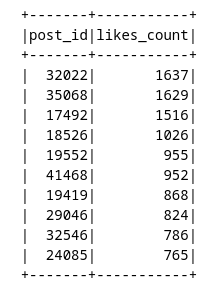

## b

In [1293]:
itmo_posts_df.select('comments').printSchema()

root
 |-- comments: struct (nullable = true)
 |    |-- can_post: long (nullable = true)
 |    |-- count: long (nullable = true)
 |    |-- groups_can_post: boolean (nullable = true)



In [1296]:
def task_1b(df: "pyspark.sql.dataframe.DataFrame", 
            F: "pyspark.sql.functions") -> "pyspark.sql.dataframe.DataFrame":
    # Place your code to transform DaraFrame here
    modified_df = df.select('id', 'comments.count').orderBy("count", ascending=False)\
    .withColumnRenamed('count', 'comments_count').withColumnRenamed('id', 'post_id')
    return modified_df

In [1297]:
result_1b = task_1b(
    df=itmo_posts_df,
    F=F
)
result_1b.show(10)

+-------+--------------+
|post_id|comments_count|
+-------+--------------+
|  24085|           850|
|  22540|           250|
|  27722|           192|
|   8285|           148|
|  26860|           113|
|  13571|           107|
|  39294|           104|
|  36680|            96|
|  26006|            92|
|  41739|            92|
+-------+--------------+
only showing top 10 rows



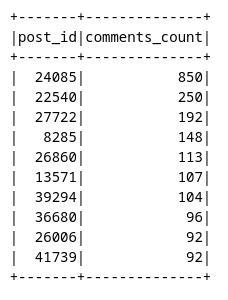

## c

In [1298]:
def task_1c(df: "pyspark.sql.dataframe.DataFrame", 
            F: "pyspark.sql.functions") -> "pyspark.sql.dataframe.DataFrame":
    # Place your code to transform DaraFrame here
    modified_df = df.select('id', 'reposts.count').orderBy("count", ascending=False)\
    .withColumnRenamed('count', 'reposts_count').withColumnRenamed('id', 'post_id')
    return modified_df

In [1299]:
result_1c = task_1c(
    df=itmo_posts_df,
    F=F
)
result_1c.show(10)

+-------+-------------+
|post_id|reposts_count|
+-------+-------------+
|  17492|          334|
|  19552|          246|
|  32022|          210|
|  11842|          129|
|  19419|          126|
|  13532|          110|
|  17014|          105|
|  35068|          101|
|  41266|           92|
|  12593|           90|
+-------+-------------+
only showing top 10 rows



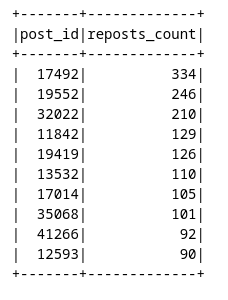

# Task 2
## a

In [829]:
followers_posts_likes_df.printSchema()

root
 |-- itemType: string (nullable = true)
 |-- ownerId: integer (nullable = true)
 |-- itemId: integer (nullable = true)
 |-- likerId: integer (nullable = true)



In [830]:
def task_2a(df: "pyspark.sql.dataframe.DataFrame", 
            F: "pyspark.sql.functions") -> "pyspark.sql.dataframe.DataFrame":
    # Place your code to transform DaraFrame here
    modified_df = df\
    .groupby("ownerId")\
    .agg(F.count("ownerId").name("count"))\
    .orderBy("count", ascending=False)
    return modified_df

In [831]:
result_2a = task_2a(
    df=followers_posts_likes_df,
    F=F
)
result_2a.show(10)

+---------+-----+
|  ownerId|count|
+---------+-----+
|289390075|82297|
|   327458|57697|
|119920644|57084|
|273486249|54882|
| 25317378|48425|
|150371150|44686|
|187877260|35507|
|   715211|30346|
|180124822|25364|
| 17885170|24749|
+---------+-----+
only showing top 10 rows



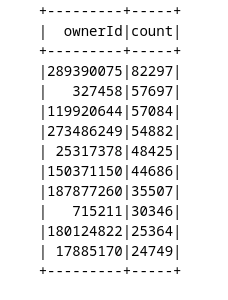

## b

In [1300]:
def task_2b(df: "pyspark.sql.dataframe.DataFrame", 
            F: "pyspark.sql.functions") -> "pyspark.sql.dataframe.DataFrame":
    # Place your code to transform DaraFrame here
    modified_df = df\
    .groupby("owner_id")\
    .agg(F.count("copy_history").name("count"))\
    .orderBy("count", ascending=False)
    return modified_df

In [1301]:
result_2b = task_2b(
    df=followers_posts_df,
    F=F
)
result_2b.show(10)

+---------+-----+
| owner_id|count|
+---------+-----+
|  2547211|37742|
|357231922|23349|
|168543860|18429|
| 25646344|11122|
|176861294| 9022|
|524656784| 7242|
|    29840| 7164|
|143207077| 7161|
|141687240| 6804|
|459339006| 6741|
+---------+-----+
only showing top 10 rows



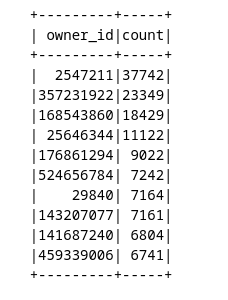

# Task 3

In [834]:
followers_posts_df.select('copy_history').printSchema()

root
 |-- copy_history: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachments: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- album: struct (nullable = true)
 |    |    |    |    |    |-- created: long (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- id: string (nullable = true)
 |    |    |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |    |    |-- size: long (nullable = true)
 |    |    |    |    |    |-- thumb: struct (nullable = true)
 |    |    |    |    |    |    |-- access_key: string (nullable = true)
 |    |    |    |    |    |    |-- album_id: long (nullable = true)
 |    |    |    |    |    |    |-- date: long (nullable = true)
 |    |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |    |-- lat: double (nullable = true)
 |    |    |    |    |    |    |-

In [835]:
itmo_posts_df.select(F.col('owner_id')).distinct().show(10)

+--------+
|owner_id|
+--------+
|    null|
|     -94|
+--------+



In [1304]:
def task_3(df: "pyspark.sql.dataframe.DataFrame", 
           F: "pyspark.sql.functions") -> "pyspark.sql.dataframe.DataFrame":
    # Place your code to transform DaraFrame here
    modified_df = df\
    .where(F.col('copy_history.owner_id').getItem(0) == -94)\
    .groupby(F.col('copy_history.id').getItem(0))\
    .agg(F.collect_set('id').name('user_post_ids'),
         F.count("copy_history").name("reposts_count"))\
    .withColumnRenamed('id', 'group_post_id')\
    .withColumnRenamed('copy_history.id[0]', 'group_post_id')\
    .withColumn("user_post_ids", F.sort_array(F.col("user_post_ids"))) \
    .orderBy(F.col("reposts_count").desc(), F.col("group_post_id").asc())
    return modified_df

In [1305]:
result_3 = task_3(
    df=followers_posts_df,
    F=F
)
result_3.show(10)

+-------------+--------------------+-------------+
|group_post_id|       user_post_ids|reposts_count|
+-------------+--------------------+-------------+
|        41266|[26, 53, 87, 88, ...|           30|
|        41468|[89, 390, 400, 44...|           25|
|        42482|[264, 713, 1190, ...|           10|
|    456239414|[25, 1063, 1266, ...|           10|
|        40090|[32, 349, 463, 13...|            9|
|        38740|[185, 1060, 1133,...|            8|
|        39259|[822, 1205, 1492,...|            8|
|        41207|[958, 1288, 2960,...|            6|
|        41546|[666, 939, 1161, ...|            6|
|        41721|[8, 274, 2801, 38...|            6|
+-------------+--------------------+-------------+
only showing top 10 rows



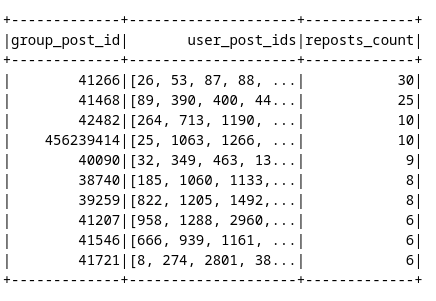

# Task 4

In [995]:
with open("/home/jovyan/shared-data/bigdata20/emojis_sentiment.json", "r") as f:
    emojis_sentiment_dict = json.loads(f.read())

In [1358]:
def task_4(df: "pyspark.sql.dataframe.DataFrame",
           F: "pyspark.sql.functions",
           T: "pyspark.sql.types",
           emojis_data: dict,
           broadcast_func: "spark.sparkContext.broadcast") -> 'Tuple["pyspark.sql.dataframe.DataFrame"]':
    # You are able to modify any code inside this function.
    # Only 'emoji' package import is allowed for this task.
    
    import emoji
    reg_exp = emoji.get_emoji_regexp()

    # 0) Helpers
    @F.udf(returnType=T.ArrayType(T.StringType()))
    def getEmojiSlice(text):
        emojis = []
        for reg_match in reg_exp.finditer(text):
            emojis.append(reg_match.group())
        return emojis

    
    broarcasted_dict = broadcast_func(emojis_data)
    @F.udf(returnType=T.StringType())
    def getSentiment(col):
        return broarcasted_dict.value.get(col, None)

    
    # 1) Gather emoji's from df
    raw_text_emoji_df = df.where(F.col("text").isNotNull())\
                            .select( F.col("id"), F.col("text"))\
                            .withColumn("emojis", getEmojiSlice("text"))\
                            .where(F.size("emojis") > 0)\
                            .select(F.col("id").name("postID"), F.col("emojis"))
    # 2) Get all emojis counted
    emoji_df = raw_text_emoji_df.select(F.explode("emojis").name("emoji"))\
                               .groupBy("emoji").agg(F.count("emoji").name("count"))\
                                .withColumn("sentiment", getSentiment(F.col("emoji")))
    
    emoji_df.show()
    
    positive_emojis = emoji_df.filter(F.col('sentiment') == 'positive').drop(F.col('sentiment'))\
    .orderBy(F.col("count").desc())
    negative_emojis = emoji_df.filter(F.col('sentiment') == 'negative').drop(F.col('sentiment'))\
                                                                               .orderBy(F.col("count").desc())
    neutral_emojis = emoji_df.filter(F.col('sentiment') == 'neutral').drop(F.col('sentiment'))\
                                                                              .orderBy(F.col("count").desc())
    
    return (positive_emojis, neutral_emojis, negative_emojis)

In [1394]:
def task_4(df: "pyspark.sql.dataframe.DataFrame",
           F: "pyspark.sql.functions",
           T: "pyspark.sql.types",
           emojis_data: dict,
           broadcast_func: "spark.sparkContext.broadcast") -> 'Tuple["pyspark.sql.dataframe.DataFrame"]':
    
    # You are able to modify any code inside this function.
    # Only 'emoji' package import is allowed for this task.
    
    import emoji
    
    broarcasted_dict = broadcast_func(emojis_data)
    
    '''Function to get all emojis from a text'''
    @F.udf(returnType=T.ArrayType(T.StringType()))
    def get_emo(col):
        return [em.group() for em in emoji.get_emoji_regexp().finditer(col)]
    
    '''Broadcating emojis'''
    @F.udf(returnType=T.StringType())
    def broadcaster(col):
        return broarcasted_dict.value.get(col, None)
    
    emos = df.where(df.text.isNotNull()).select(df.text, F.col("id"))\
    .withColumn('emoji_arr', get_emo(df.text))\
    .where(F.size("emoji_arr") > 0)\
    .select(F.col("id"), F.col("emoji_arr"))

    emos_count = emos.select(F.explode("emoji_arr").name("emoji"))\
    .groupBy('emoji').agg(F.count('emoji').alias('count'))\
    .withColumn('sentiment', broadcaster(F.col('emoji')))
    
    positive_emojis = emos_count.filter(F.col('sentiment') == 'positive').drop(F.col('sentiment'))\
    .orderBy(F.col("count").desc())
    negative_emojis = emos_count.filter(F.col('sentiment') == 'negative').drop(F.col('sentiment'))\
                                                                               .orderBy(F.col("count").desc())
    neutral_emojis = emos_count.filter(F.col('sentiment') == 'neutral').drop(F.col('sentiment'))\
                                                                              .orderBy(F.col("count").desc())
    
    return (positive_emojis, neutral_emojis, negative_emojis)

In [1395]:
positive_emojis, neutral_emojis, negative_emojis = task_4(
    df=followers_posts_df,
    F=F,
    T=T,
    emojis_data=emojis_sentiment_dict,
    broadcast_func=spark.sparkContext.broadcast
)

positive_emojis.show(10)
neutral_emojis.show(10)
negative_emojis.show(10)

+-----+-----+
|emoji|count|
+-----+-----+
|    ❤|15238|
|   👍| 6538|
|   😂| 5554|
|   🌺| 5470|
|   😍| 4583|
|   🔻| 4115|
|   🎀| 3788|
|   😉| 3687|
|    ☀| 3243|
|    ✅| 2985|
+-----+-----+
only showing top 10 rows

+-----+-----+
|emoji|count|
+-----+-----+
|   🔥|11774|
|    ®| 9144|
|   💥| 4669|
|    ❗| 3563|
|    ✨| 2833|
|   💰| 1365|
|    ©| 1150|
|   💣| 1124|
|    ✔| 1086|
|    ⚠| 1040|
+-----+-----+
only showing top 10 rows

+-----+-----+
|emoji|count|
+-----+-----+
|   📌| 1427|
|   😭|  483|
|   😔|  251|
|   💔|  251|
|    ➖|  249|
|   😨|  241|
|   😤|  206|
|   🔫|  194|
|   😲|  192|
|   😾|  165|
+-----+-----+
only showing top 10 rows



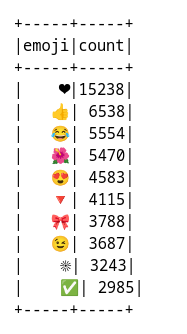
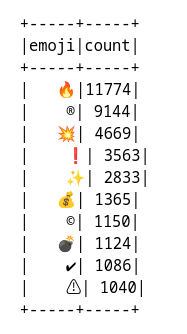
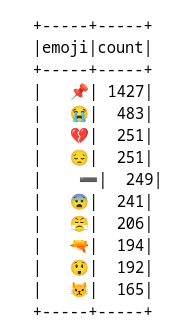

# Task 5

In [979]:
followers_posts_likes_df.printSchema()

root
 |-- itemType: string (nullable = true)
 |-- ownerId: integer (nullable = true)
 |-- itemId: integer (nullable = true)
 |-- likerId: integer (nullable = true)



In [1132]:
def task_5(df: "pyspark.sql.dataframe.DataFrame",
           F: "pyspark.sql.functions",
           W: "pyspark.sql.window.Window",
           top_n_likers: int) -> "pyspark.sql.dataframe.DataFrame":
    # Place your code to transform DaraFrame here
    df = df.filter(F.col("ownerId") != F.col("likerId")).groupBy('ownerId', 'likerId')\
    .agg(F.count('likerId').alias('count')).orderBy("ownerId", ascending=True)

    window = W.partitionBy("ownerId").orderBy(F.desc("count"))
    modified_df = df.withColumn("rank", F.row_number().over(window)) \
                                        .filter(F.col("rank") <= top_n_likers)\
    .select("ownerId", "likerId", "count")\
    .orderBy(F.col("ownerId").asc(), F.col('count').desc(), F.col('likerId').asc())

    return modified_df

In [1133]:
result_5 = task_5(
    df=followers_posts_likes_df,
    F=F,
    W=Window,
    top_n_likers=10
)
result_5.show(15)

+-------+---------+-----+
|ownerId|  likerId|count|
+-------+---------+-----+
|    637|   422527|   24|
|    637| 13237321|   21|
|    637|   162706|   20|
|    637|   392577|   16|
|    637|151081369|   16|
|    637| 49547307|   15|
|    637|145422426|   15|
|    637|   407844|   14|
|    637|    94399|   13|
|    637|   359267|   13|
|   1087| 84798348|   48|
|   1087|354351777|   30|
|   1087|230753056|   26|
|   1087|255139140|   23|
|   1087|499354771|   22|
+-------+---------+-----+
only showing top 15 rows



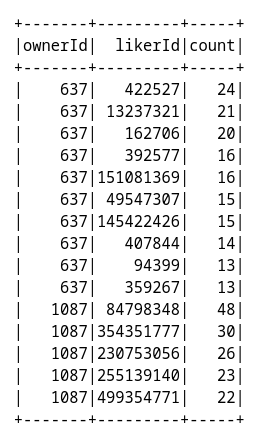

# Task 6

In [1203]:
followers_posts_likes_df.printSchema()

root
 |-- itemType: string (nullable = true)
 |-- ownerId: integer (nullable = true)
 |-- itemId: integer (nullable = true)
 |-- likerId: integer (nullable = true)



In [1312]:
def task_6(df: "pyspark.sql.dataframe.DataFrame",
           F: "pyspark.sql.functions",
           W: "pyspark.sql.window.Window") -> "pyspark.sql.dataframe.DataFrame":
    # Place your code to transform DaraFrame here
    df = df.filter(F.col("ownerId") != F.col("likerId")).groupBy('ownerId', 'likerId')\
    .agg(F.count('likerId').alias('count')).orderBy(F.col("ownerId").asc(),F.col('count').desc())
    
    Win = W.partitionBy('likerId').orderBy(F.col('count').desc(), F.col('likerId').asc())
    
    df = df.withColumn('max', F.max('count').over(Win)).where(F.col('count') == F.col('max'))\
    .drop('max')
    
    df1 = df.alias('df1').withColumnRenamed('ownerId', 'df1_ownerId')\
                                  .withColumnRenamed('likerId', 'df1_likerId')\
                                  .withColumnRenamed('count', 'df1_count')
    df2 = df.alias('df2').withColumnRenamed('count', 'df2_count')

    common_pairs = df1.join(df2, (df1['df1_ownerId'] == df2['likerId']) & (df1['df1_likerId'] == df2['ownerId'])&
                                  (df1['df1_ownerId']<df2['ownerId']), 'inner') \
    .select(df1['df1_ownerId'], df1['df1_likerId'], df1['df1_count'], df2['ownerId'], df2['likerId'], df2['df2_count'])


    window = W.partitionBy("df1_ownerId").orderBy(F.asc("df1_ownerId"), F.desc("df1_count"), F.desc("df2_count"))
    window2 = W.orderBy(F.col("mutual_likes").desc(), F.col("user_a").asc(), F.col("user_b").asc())
    #window3 = Window.partitionBy("user_a", "user_b").orderBy(F.col("mutual_likes").desc(), F.col("user_a").asc(), F.col("user_b").asc())

    modified_df = common_pairs.withColumn("rank", F.row_number().over(window)) \
                                        .filter(F.col("rank") == 1)\
    .select(F.col("likerId").alias('user_a'), F.col("df1_likerId").alias('user_b'), F.col("df1_count")\
            .alias('likes_from_a'), F.col('df2_count').alias('likes_from_b'))\
    .withColumn('mutual_likes', F.col('likes_from_a')+F.col('likes_from_b'))\
    .withColumn('filter', F.lag("user_a", default = 1).over(window2))\
    .filter(F.col('user_b') != F.col('filter'))\
    .drop(F.col('filter'))\
    .orderBy(F.col("mutual_likes").desc(), F.col("user_a").asc(), F.col("user_b").asc())
    
    return modified_df

In [1313]:
result_6 = task_6(
    df=followers_posts_likes_df,
    F=F,
    W=Window
)
result_6.show(15)

+---------+---------+------------+------------+------------+
|   user_a|   user_b|likes_from_a|likes_from_b|mutual_likes|
+---------+---------+------------+------------+------------+
| 13675440|183535934|         100|         161|         261|
|207134315|208946862|          52|          31|          83|
|145105762|267301242|          28|          52|          80|
|155963006|162366815|          57|          12|          69|
|   135451| 18737802|          18|          45|          63|
| 53368685|322831238|          52|          11|          63|
|121608397|441534917|          57|           3|          60|
|101767883|188548515|           6|          52|          58|
|209077977|272076217|          18|          40|          58|
|   460957|   715211|           2|          53|          55|
|    45781|    58440|          47|           4|          51|
| 19261491|229861638|          26|          23|          49|
| 52612744| 53720099|          17|          32|          49|
|   667303|  1113545|   

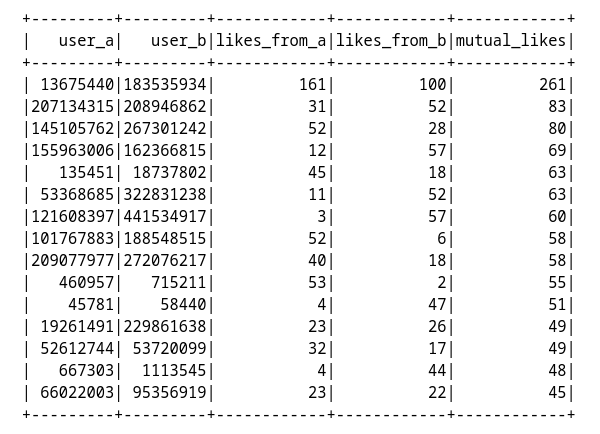